# Final steps - Subsetting the data, Modeling, Hyperparameter finetuning

## Subsetting the dataset
 
Now when the flat file is ready for modeling, partitions will be generated to be used for modeling. The first partition to be generated is the "test" dataset. This dataset will be set on hold aside and only used at the end of the whole process of training and selecting the best model.
 
After selecting the "test" dataset I proceed to use the rest of the data to devide into "train" and "val" for training the models.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
# ignore DataConversionWarning warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action = 'ignore', category = DataConversionWarning)
np.random.seed(1)
random.seed(1)
import seaborn as sns
from collections import Counter
import pickle

Import of 'ff_train_agg' dataset from check point 3:

In [2]:
ff_train_agg = pd.read_csv("C:/Users/Avishai/Documents/General/Personal/DS Course/Google drive content/Projects/Final project-ASHRAE-Great Energy Predictor III/Data/CheckPoint3/ff_train_agg.csv")
ff_train_agg

,site_id,building_id,date,time_range_x_mode,time_range_y_mode,meter_reading_sum,precip_depth_min,precip_depth_max,precip_depth_sd,air_temperature_min,...,is_precip_air_temperature_mean,is_even_cloud_coverage,dew_temperature_sd_sqrt,sea_level_pressure_sd_sqrt,rel_humid_sd_sqrt,is_missing_year_built,is_missing_sea_level_pressure_min,is_missing_dew_temperature_sd_sqrt,is_missing_sea_level_pressure_sd_sqrt,is_missing_rel_humid_sd_sqrt
0,0,103,2016-02-29,-0.5,-0.866,3672.32,0,0,0,13.3,...,1,1,3,4,4,0,0,0,0,0
1,0,103,2016-02-29,1.0,0.000,1350.74,0,0,0,16.7,...,1,1,4,3,4,0,0,0,0,0
2,0,103,2016-03-01,-0.5,0.866,1266.30,0,0,0,13.9,...,1,1,3,2,2,0,0,0,0,0
3,0,103,2016-03-01,1.0,0.000,1604.00,0,0,0,17.8,...,1,1,4,2,4,0,0,0,0,0
4,0,103,2016-03-02,-0.5,0.866,1604.00,0,0,0,14.4,...,1,1,2,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418846,15,1413,2016-12-29,-0.5,-0.866,30.26,0,2,3,-1.7,...,1,1,3,4,2,0,0,0,0,0
418847,15,1413,2016-12-29,1.0,0.000,26.20,0,0,0,-1.7,...,1,1,3,2,3,0,0,0,0,0
418848,15,1413,2016-12-30,-0.5,0.866,28.67,0,0,0,-1.7,...,1,1,2,2,2,0,0,0,0,0
418849,15,1413,2016-12-31,-0.5,0.866,27.89,0,0,0,-4.4,...,1,0,2,1,1,0,0,0,0,0


A check wether there are buildings with very few records:

In [3]:
# Group by 'site_id' and 'building_id' and count the number of rows
grouped = ff_train_agg.groupby(['site_id', 'building_id']).size().reset_index(name = 'count')
min_records_number = 100
small_combinations = grouped[grouped['count'] < min_records_number]  
small_combinations

,site_id,building_id,count
261,10,1018,1
262,10,1022,6


Two buildings with less than 100 records are found.

Create a list of dataframes where each element is different building data

In [4]:
# Get a list of unique site_id values
unique_site_ids = ff_train_agg['site_id'].unique()

# Initialize a list to store the various building data. Each element is a data frame
buildings_dataframes = []

for site_id in unique_site_ids:
    # Filter data for the current 'site_id'
    site_data = ff_train_agg[ff_train_agg['site_id'] == site_id]

    # Get a list of unique 'building_id' values within the current 'site_id'
    unique_building_ids = site_data['building_id'].unique()

    for building_id in unique_building_ids:
        # Filter data for the current 'building_id' within the 'site_id'
        building_data = site_data[site_data['building_id'] == building_id]

        # Sort the data by 'date' to maintain temporal order
        building_data = building_data.sort_values(by = 'date')

        # Check if the current data is sufficient for splitting to 'train', 'val' and 'test'
        if len(building_data) >= min_records_number:
            # I dropp id variables and all the variables that have many categories as it's not good for the models
            buildings_dataframes.append(building_data.drop(['site_id', 'building_id', 'date'], axis = 1))

I will randomly select and visualize data of different buildings while applying 'Principal Component Analysis' (PCA) for dimensionality reduction. The plot will show the data from various building clusters in the reduced-dimensional space. Based on the degree of foreignness of the resulting clusters, I will make a decision whether to build one model for all the buildings or a separate model for each building. In order to build a separate model for each building, I would like to see a clear distinction between the clusters.

Principal Component Analysis (PCA):

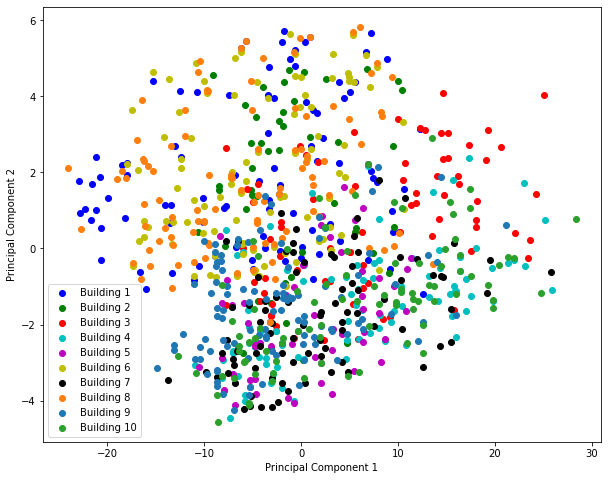

In [5]:
# Set the number of distinct buildings to be randomly selected for the graph
num_buildings_to_select = 10


combined_data = []     # Initialize a list to store the selected data of each building
chosen_indexes = []    # the indexes of the selected data of each building taken from 'buildings_dataframes'
chosen_buildings_dfs_lengths = []    # store the lengths of the selected building subsets

# Randomly select 10 building data subsets
for _ in range(num_buildings_to_select):
    # Select a random number between 0 and len(buildings_dataframes) - 1
    random_index = random.randint(0, len(buildings_dataframes) - 1)
    
    # Make sure that the same building is not sampled twice
    while random_index in chosen_indexes:
        random_index = random.randint(0, len(buildings_dataframes) - 1)
    
    chosen_indexes.append(random_index)
    selected_partition = buildings_dataframes[random_index]
    
    # Take only 10% of the selected partition, So that the plot is not overloaded with points
    selected_partition = selected_partition.sample(frac = 0.1)
    chosen_buildings_dfs_lengths.append(len(selected_partition))
    
    combined_data.append(selected_partition)

# Concatenate data frames within the list into a single larger data frame
combined_data = pd.concat(combined_data)

# Create a data frame that excludes the outcome variable from the concatenated data frame 
features = combined_data.drop(['meter_reading_sum'], axis = 1)

# Initializes a PCA object with the desired number of components (2 components in this case)
# I choose 2 components to be applied, so that results can be visualozed in a 2D plot
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(features)

# Create a plot
plt.figure(figsize = (10, 8))    # Sets up a matplotlib figure 

# Initializes a list of colors will be used for plotting different building partitions (subsets)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#ff7f0e', '#1f77b4', '#2ca02c']

# Plot the PCA-transformed data with a unique color for each partition 
for i in range(num_buildings_to_select):
    # Determine the range of data points corresponding to the current partition
    start_index = sum(chosen_buildings_dfs_lengths[:i])
    end_index = sum(chosen_buildings_dfs_lengths[:i + 1])
    # The first 2 arguments represent the x-coordinate of the PCA-transformed data points within the specified range from 'start_index' to 'end_index'
    plt.scatter(pca_result[start_index:end_index, 0], pca_result[start_index:end_index, 1], label = f'Building {i + 1}', c = colors[i])

# Set plot labels and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

The plot shows foreignness between clusters. In this case, the predictive ability of a single model based on all-building data will be limited for a specific building. Thus I will implement a separate machine learning models for each building in each site. Therefore I will generate a set of 'train', 'val', and 'test' data for each "building_id" in each "site_id", where the sets maintain temporal order by 'date'. Some buildings have more data available than others, so sizes of the data subsets for different buildings may vary. Buildings with very little data will not be taken, as specified earlier.

Splitting the dataset to train, val and test:

In [6]:
# Initialize 3 lists to store a set of 3 partitions: 'train' 'val' and 'test' for each unoque building
train_partitions = []
val_partitions = []
test_partitions = []

for building_data in buildings_dataframes:
    # Check if the available data is sufficient for splitting
    if len(building_data) >= min_records_number:
        # Split the data into 'train,' 'val,' and 'test' partitions with specified percentages
        train, test = train_test_split(building_data, test_size = 0.15, shuffle = False)
        train, val = train_test_split(train, test_size = 0.18, shuffle = False)

        # Append the partitions to the lists
        train_partitions.append(train)
        val_partitions.append(val)
        test_partitions.append(test)

Now there are separate partitions for each unique 'building_id' within each 'site_id'. 'train_partitions', 'val_partitions', and 'test_partitions' are lists of dataframes, where
each element in the lists corresponds to a unique 'building_id' within a specific 'site_id'.

Evaluation: I choose to use the |"MSE" type of error due to nature of the task (regression) and the absence of outliers.

The modelss will be used are: Linear Regression, Decision Tree Regressor, Support Vector Machine (SVR) (multiple kernels), AdaBoost Regressor, Gradient Boosting Regressor, Random Forest Regressor.

The following scheme describes the code in the cell below (this scheme is applied for every building):

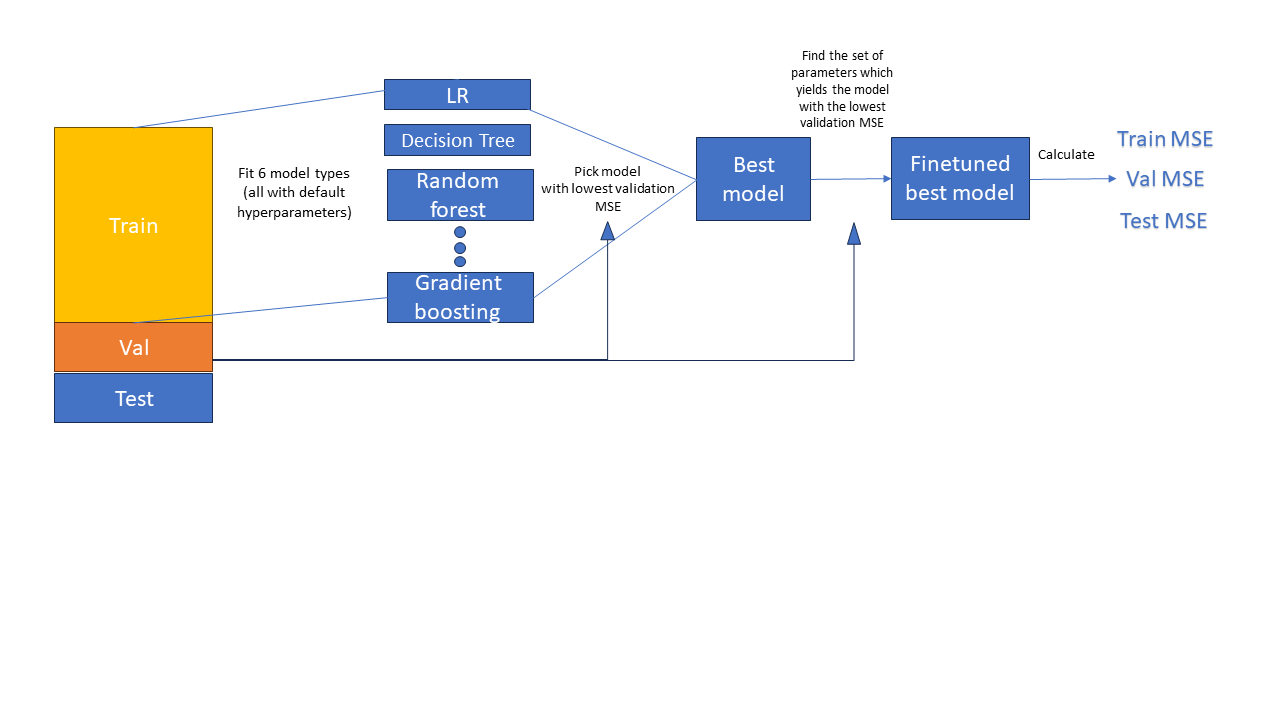

# Creating Models for Each Building

#### Data Extraction Function:

In [7]:
def extract_data_from_df(b_train, b_val, b_test):
    X_train = b_train.drop(columns = ['meter_reading_sum']) #  Drop the outcome column from "train" set (keep only the features)
    y_train = b_train['meter_reading_sum'] #  Keep the outcome column only at "train" set
    X_val = b_val.drop(columns = ['meter_reading_sum']) #  Drop the outcome column from "val" set (keep only the features)
    y_val = b_val['meter_reading_sum'] #  Keep only the outcome column at 'val' set
    X_test = b_test.drop(columns = ['meter_reading_sum']) #  Drop the outcome column from "test" set (keep only the features)
    y_test = b_test['meter_reading_sum'] #  Keep the outcome column only at "test" set
    return X_train, y_train, X_val, y_val, X_test, y_test

#### Data Normalization Function

This section scales both the features and the outcome variable. Scaling the features is important because some features may have a larger range of values than others, which can cause the model to be biased towards those features. Normalization helps to avoid this bias. 
Although outcome variable should not always be normalized, in this case it is necessary to be made, because the outcome variable's scale made it difficult for the optimization algorithm to converge. Normalizing the outcome variable helps the optimization algorithm to converge faster and to find a better solution.




I fit the scaler on the training set and then apply the same transformation to the validation and test sets. This practice is essential for several reasons:

1. Preventing Data Leakage: It ensures that the transformation is learned only from the training data. This prevents data leakage, where information from the validation or test set influences the transformation, potentially leading to overfitting and incorrect model evaluations.

2. Model Simulation: When we apply machine learning models to new, unseen data in the real world, we won't have access to the validation and test sets for scaling. By learning the transformation parameters (e.g., mean and standard deviation for standardization) from the training data, you simulate the real-world scenario where you need to apply the same transformation learned from your training data.

3. Consistency: Using the same transformation for all datasets ensures consistency in how data is processed. This is crucial for model evaluation and comparison across datasets.

4. Reducing Information Leakage: Applying different transformations to the training, validation, and test sets can introduce discrepancies and biases in the data, potentially leading to erroneous model performance evaluations.

In summary, fitting data transformations on the training set and applying them to the validation and test sets is a best practice in machine learning to ensure accurate and consistent model training and evaluation.

In [8]:
def scale_data(X_train, y_train, X_val, y_val, X_test, y_test):
    """ 
    The function returns the scaled features and target variables for training, validation, and 
    testing, as well as the fitted scalers. """ 

    # fit a scaler to the training set and use it to scale the training, validation and testing sets
    scaler = StandardScaler()                  # initializes a 'StandardScaler' for scaling the features
    scaler.fit(X_train)                        # fits (computes "mean" and "standard deviation")
    
    X_train = scaler.transform(X_train)        # transforms (scales)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # scale also the outcome values
    y_scaler = StandardScaler()
    y_scaler.fit(y_train.values.ravel().reshape(-1, 1))  # values.ravel().reshape(-1, 1) - Help prepare the target variable for scaling
    
    y_train = y_scaler.transform(y_train.values.ravel().reshape(-1, 1))
    y_val = y_scaler.transform(y_val.values.ravel().reshape(-1, 1))
    y_test = y_scaler.transform(y_test.values.ravel().reshape(-1, 1))
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, y_scaler

#### Model Selection Function

When comparing between models, I will fit each one (with default parameters) on the training set and evaluate it on the validation set. The model with the lowest validation error (MSE) will be selected as the best model. 

In [9]:
def select_best_model(model_names, models, X_train, y_train, X_val, y_val):
    """
    This function finds and return the model from a list of models that performs 
    the best on a validation set based on the 'MSE'. 
    
    This function uses "grid search" principle to find the best model out of the models specified above.
    It then fits the best model to the training set and returns it.
    
    Parameters:
    model_names (list): a list containing the names of the models
    models (list): a list containing the models
    X_train (numpy array): the feature values of the training set
    y_train (numpy array): the target values of the training set
    X_val (numpy array): the feature values of the validation set
    y_val (numpy array): the target values of the validation set
    
    Returns:
    best_model (sklearn model): the best model
    best_model_name (string): the best model's name
    """
    best_model = None # the model with the lowest 'MSE' on the validation set. Declare the variable and provide a baseline for comparison
    best_model_name = None # the name of the model with the lowest 'MSE' on the validation set
    best_MSE = np.inf # holds the lowest 'MSE' on the validation set (is initialized to infinity because I want to minimize it)
    # for each model calculate the 'MSE' on the validation set
    for model_name, model in zip(model_names, models):
        model.fit(X_train, y_train) # train the model (fit it to the training set)
        y_pred = model.predict(X_val) # use the trained model to predict the target values of the validation set
        mse = mean_squared_error(y_val, y_pred) # calculate the 'MSE' between the predicted values and the actual values of the validation set
        if mse < best_MSE: # if the 'MSE' is lower than the current best MSE', update the best 'MSE', best model and best model name
            best_model = model
            best_model_name = model_name
            best_MSE = mse
    return best_model, best_model_name

#### Hyper Parameter Tuning Functions

To remind, first I compare between the models using their default parameters. After the best model is found, its hyperparameters are tuned.
The set of hyperparameters to optimize is dependent on the model type (e.g "linear regression" has no hyperparameters to optimize and "DecisionTreeRegressor" is optimized by max depth, minimum number of samples in each split and minimum number of samples in each leaf).

The function "create_param_grid" creates a dictionary of hyperparameters to optimize each model type.

The function "finetune_model" is used to find the best hyperparameters for each model type and returns the finetuned model and the best set of hyperparameters.


In [10]:
def create_param_grid(best_model):
    # The function creates a dictionary of hyperparameters to optimize each model type
    
    if isinstance(best_model, LinearRegression):
        # no hyperparameters to tune
        param_grid = None
    elif isinstance(best_model, DecisionTreeRegressor):
        # use grid search to find the best hyperparameters: "max_depth", "min_samples_split", "min_samples_leaf"
        param_grid = {
            'max_depth': [2, 3, 4, 5],
            'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3, 4, 5]
        }
    elif isinstance(best_model, SVR):
        # use grid search to find the best hyperparameters: "kernel", "C", "gamma"
        param_grid = {
            'kernel': ['linear', 'poly', 'rbf'],
            'C': [0.1, 1, 10, 100],
            }
    elif isinstance(best_model, AdaBoostRegressor):
        # use grid search to find the best hyperparameters: "n_estimators", "learning_rate"
        param_grid = {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.1, 1, 10]
            }
    elif isinstance(best_model, GradientBoostingRegressor):
        # use grid search to find the best hyperparameters: "n_estimators", "learning_rate", "max_depth", "min_samples_split", "min_samples_leaf"
        param_grid = {
            'n_estimators': [50, 100, 150, 200],
            # 'learning_rate': [0.1, 1, 10, 100],
            'max_depth': [2, 3, 4, 5],
            # 'min_samples_split': [2, 3, 4, 5],
            # 'min_samples_leaf': [1, 2, 3, 4, 5]
            }
    elif isinstance(best_model, RandomForestRegressor):
        # use grid search to find the best hyperparameters: n_estimators, "max_depth", "min_samples_split", "min_samples_leaf"
        param_grid = {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [2, 3, 4, 5],
            # 'min_samples_split': [2, 3, 4, 5],
            # 'min_samples_leaf': [1, 2, 3, 4, 5]
            }
    return param_grid


def finetune_model(param_grid, model, X_train, y_train, X_val, y_val):
    """
    This function operates fine-tuning on a model using grid search. It takes a set of hyperparameters 
    ("param_grid") and searches for the best combination of hyperparameters to optimize model performance.
    It then fits the model to the training set according to the best set of hyperparameters.
    
    Parameters:
    param_grid (dict): a dictionary containing the hyperparameters to tune and the values to try for each hyperparameter
    model (sklearn model): the model to finetune
    X_train (numpy array): the feature values of the training set
    y_train (numpy array): the target values of the training set
    X_val (numpy array): the feature values of the validation set
    y_val (numpy array): the target values of the validation set
    
    Returns:
    model (sklearn model): the finetuned model
    best_grid (dict): the best set of hyperparameters found by grid search
    """
    if param_grid is None: # if there are no hyperparameters to tune, just fit the model to the training set and return it
        model.fit(X_train, y_train)
        return model, None
    
    # A check to ensure that "param_grid" is a dictionary before proceeding with the hyperparameter tuning process
    assert isinstance(param_grid, dict)   # it's a safeguard against incorrect input
    best_grid = None
    best_MSE = np.inf

    # Iterate through different hyperparameter combinations
    # Each combination is represented by a dictionary "g".
    for g in ParameterGrid(param_grid):  
        try:
            # sets the hyperparameters of the model to the current combination (g), using the "**" operator to unpack the dictionary
            model.set_params(**g)
            model.fit(X_train, y_train) # fit the model to the training set, using the current hyperparameter combination
            
            val_preds = model.predict(X_val) # use the model with the current hyperparameter combination to predict the target values of the validation set
            val_mse = mean_squared_error(y_val, val_preds) # compute the "MSE" between the predicted values and the actual values of the validation set
            if val_mse < best_MSE: # if the "MSE" is lower than the current best "MSE", update the best "MSE" and best grid (set of hyperparameters)
                best_MSE = val_mse
                best_grid = g
                
        except:
            print(f'the model {model} crashed')
    
    if best_grid is not None:
        model.set_params(**best_grid) # set the hyperparameters of the model to the best set of hyperparameters
        model.fit(X_train, y_train) # fit the model to the training set according to the best set of hyperparameters
    return model, best_grid

#### Feature Selection Function

I will do a feature selection after I had found the best model and the best hyperparameters for it. I will use the "feature importance" of the best model to select the final features.
I will keep only the top half of the features (all featuers with importance score above the median).
After I drop the non-important features, I will retrain the model.

In [11]:
def select_features(best_model, X_train, y_train, X_val, X_test, b_train, models, model_names, best_model_name, best_hyperparameters):
    """
    This function uses the best model found in the privious section to select the most important features. Use "SelectFromModel" 
    to select the most important features according to the best model, then use the selected features to rebuild 
    the training, validation and test sets. Finally finetune the updated (by the feature selection) best model on the new 
    training and validation sets.

    Parameters:
    best_model (sklearn model): the best model found in the previous section
    X_train (numpy array): the feature values of the training set
    y_train (numpy array): the target values of the training set
    X_val (numpy array): the feature values of the validation set
    X_test (numpy array): the feature values of the test set
    b_train (pandas dataframe): the training set
    models (list): a list containing the models
    model_names (list): a list containing the names of the models
    best_model_name (string): the name of the best model
    best_hyperparameters (dict): the best combination of hyperparameters found by grid search
    
    Returns:
    selected_features (list): a list containing the names of the selected features
    X_train (numpy array): the feature values of the training set after feature selection
    X_val (numpy array): the feature values of the validation set after feature selection
    X_test (numpy array): the feature values of the test set after feature selection
    best_model (sklearn model): the best model after feature selection and retraining
    """
    
    selected_features = b_train.columns # initialize the set of selected features to be all the features
    if not isinstance(best_model, SVR):
        #  A way to check whether a particular condition holds true during the execution of a program
        # If best_model doesn't have either attribute, it could be a sign that this model is not suitable for feature selection
        assert hasattr(best_model, 'coef_') or hasattr(best_model, 'feature_importances_')
        selector = SelectFromModel(best_model, threshold = 'median')  # select the most important features according to the best model
        selector.fit(X_train, y_train)
        selected_features = b_train.columns[selector.get_support(indices = True)] # get the names of the selected features
        
        # rebuild the training, validation and test sets with the selected features
        X_train = selector.transform(X_train)
        X_val = selector.transform(X_val)
        X_test = selector.transform(X_test)
        
        # recreate the best model with the selected features and the best hyperparameters
        best_model = models[model_names.index(best_model_name)]
        if best_hyperparameters is not None: # can happen if the best model has no hyperparameters to tune (like in linear regression)
            best_model.set_params(**best_hyperparameters)
        
        best_model.fit(X_train, y_train)
    return selected_features, X_train, X_val, X_test, best_model

## Putting it all together - Creating models for all buildings and saving the results

In [12]:
buildings_models_dict = {}  # This dictionary will be used to store information about the best models and their performance for each building
for i, (b_train, b_val, b_test) in enumerate(zip(train_partitions, val_partitions, test_partitions)):
    X_train, y_train, X_val, y_val, X_test, y_test = extract_data_from_df(b_train, b_val, b_test)
    
    
    '''
    **DATA SCALING** In this section::: I scale the features and the target values of the training, validation and test sets.
    The important thing to note is that I fit the scaler to the TRAINING set and use it to scale the validation and test sets.
    I decided to scale the target values as well as I wanted to use "MSE" as our metric and "MSE" is sensitive to the scale 
    of the target values (I got "MSE" overflow for some models when I didn't scale the target values).
    '''
    # fit a scaler to the training set and use it to scale the training, validation and test sets
    X_train, y_train, X_val, y_val, X_test, y_test, scaler, y_scaler = scale_data(X_train, y_train, X_val, y_val, X_test, y_test)
    
    
    # use "linear regression", "decision tree regressor", "random forest regressor", "SVR" (with multiple kernels), "ADABOOST regressor", "gradient boosting regressor"
    model_names = ['linear regression', 'decision tree regressor', 'random forest regressor', 'SVR', 'ADABOOST regressor', 'gradient boosting regressor']
    models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), SVR(), AdaBoostRegressor(), GradientBoostingRegressor()]
    
    ''' 
    **MODEL SELECTION** In this section::: I find the best model out of the models defined above. I do this by training each 
    model (with default hyperparameters) on the training set and calculating the "MSE" on the validation set. The model with the 
    lowest "MSE" on the validation set is the best model.
    '''    
    best_model, best_model_name = select_best_model(model_names, models, X_train, y_train, X_val, y_val)
    
    ''' 
    **HYPERPARAMETER TUNING** In this section::: I finetune the best model found in the previous section. First I define the 
    hyperparameters to tune for each model (according to the "sklearn" documentation), and then I use grid search to find the 
    best set of hyperparameters.
    '''    
    param_grid = create_param_grid(best_model)
    
    best_model, best_hyperparameters = finetune_model(param_grid, best_model, X_train, y_train, X_val, y_val)
    
    
    '''
    **FEATURE SELECCTION** In this section::: I use the best model found in the previous section to select the most important 
    features. I use "SelectFromModel" to select the most important features according to the best model. Then I use the selected 
    features to rebuild the training, validation and test sets. Finally, 
    I finetune the best model on the new training and validation sets.
    '''
    '''
    "SVR" does not have a "coef_" or "feature_importances_" attribute (In order to do feature selection by "SVR" I will need 
    something like "permutation importance" or "SHAP" values which are expensive to compute (possible, but takes a long time)))) If 
    you want to add "permutation importance", use this thread: https://stackoverflow.com/questions/70467781/feature-importance-with-svr.
    '''
    
    selected_features, X_train, X_val, X_test, best_model = select_features(best_model, X_train, y_train, X_val, X_test, b_train, models, model_names, best_model_name, best_hyperparameters)
    
    '''
    **MAKING FINAL PREDICTIONS** In this section::: I calculate the "MSE" of the best model on the training, validation and test sets.     
    '''
    best_model_train_pred = best_model.predict(X_train) # use the trained finetuned model to predict the target values of the training set
    best_model_train_mse = mean_squared_error(y_train, best_model_train_pred) # calculate the "MSE" between the predicted values and the actual values of the training set
    
    best_model_val_pred = best_model.predict(X_val) # use the trained finetuned model to predict the target values of the validation set
    best_model_val_mse = mean_squared_error(y_val, best_model_val_pred) # calculate the "MSE" between the predicted values and the actual values of the validation set
    
    best_model_test_pred = best_model.predict(X_test) # use the trained finetuned model to predict the target values of the test set
    best_model_test_mse = mean_squared_error(y_test, best_model_test_pred) # calculate the "MSE" between the predicted values and the actual values of the test set
    
    # For the current building, add the best model, best model name, best model train MSE, best model val MSE and best model test MSE to the dictionary
    
    buildings_models_dict[i] = {
        'best model name': best_model_name,
        'best hyperparameters': best_hyperparameters if best_hyperparameters is not None else 'Default',
        'selected features': selected_features,
        'best model train MSE': best_model_train_mse,
        'best model val MSE': best_model_val_mse,
        'best model test MSE': best_model_test_mse,
        'features scaler': scaler,
        'target values scaler': y_scaler, # I save the y_scaler as I need it to inverse the scaling of the target values, when I want to make real predictions on new data (for the model I need the normalized data but IRL I want the actual values) 
    }
    
    print(f'building {i+1} done: {best_model_name}')

# save the dictionary to a file
with open('buildings_models_dict', 'wb') as f:
    pickle.dump(buildings_models_dict, f)

# load the dictionary from a file
# It shouldn't run unless i need to load that info to a dictionary again
# with open('buildings_models_dict', 'rb') as f:
# buildings_models_dict = pickle.load(f)

building 1 done: ADABOOST regressor
building 2 done: gradient boosting regressor
building 3 done: gradient boosting regressor
building 4 done: gradient boosting regressor
building 5 done: linear regression
building 6 done: SVR
building 7 done: linear regression
building 8 done: random forest regressor
building 9 done: linear regression
building 10 done: ADABOOST regressor
building 11 done: random forest regressor
building 12 done: gradient boosting regressor
building 13 done: gradient boosting regressor
building 14 done: SVR
building 15 done: gradient boosting regressor
building 16 done: decision tree regressor
building 17 done: ADABOOST regressor
building 18 done: gradient boosting regressor
building 19 done: linear regression
building 20 done: SVR
building 21 done: SVR
building 22 done: linear regression
building 23 done: SVR
building 24 done: gradient boosting regressor
building 25 done: gradient boosting regressor
building 26 done: ADABOOST regressor
building 27 done: gradient boos

building 229 done: SVR
building 230 done: gradient boosting regressor
building 231 done: ADABOOST regressor
building 232 done: gradient boosting regressor
building 233 done: random forest regressor
building 234 done: random forest regressor
building 235 done: linear regression
building 236 done: random forest regressor
building 237 done: gradient boosting regressor
building 238 done: SVR
building 239 done: gradient boosting regressor
building 240 done: random forest regressor
building 241 done: linear regression
building 242 done: linear regression
building 243 done: linear regression
building 244 done: SVR
building 245 done: linear regression
building 246 done: random forest regressor
building 247 done: random forest regressor
building 248 done: gradient boosting regressor
building 249 done: gradient boosting regressor
building 250 done: gradient boosting regressor
building 251 done: gradient boosting regressor
building 252 done: gradient boosting regressor
building 253 done: gradient

building 440 done: gradient boosting regressor
building 441 done: random forest regressor
building 442 done: gradient boosting regressor
building 443 done: random forest regressor
building 444 done: gradient boosting regressor
building 445 done: gradient boosting regressor
building 446 done: gradient boosting regressor
building 447 done: gradient boosting regressor
building 448 done: random forest regressor
building 449 done: decision tree regressor
building 450 done: gradient boosting regressor
building 451 done: linear regression
building 452 done: gradient boosting regressor
building 453 done: random forest regressor
building 454 done: random forest regressor
building 455 done: gradient boosting regressor
building 456 done: random forest regressor
building 457 done: SVR
building 458 done: gradient boosting regressor
building 459 done: SVR
building 460 done: random forest regressor
building 461 done: SVR
building 462 done: random forest regressor
building 463 done: gradient boosting 

In [13]:
buildings_models_df = pd.DataFrame(buildings_models_dict).T
buildings_models_df

,best model name,best hyperparameters,selected features,best model train MSE,best model val MSE,best model test MSE,features scaler,target values scaler
0,ADABOOST regressor,"{'learning_rate': 1, 'n_estimators': 100}","Index(['time_range_x_mode', 'time_range_y_mode...",0.047714,0.110847,0.10905,StandardScaler(),StandardScaler()
1,gradient boosting regressor,"{'max_depth': 2, 'n_estimators': 100}","Index(['time_range_x_mode', 'time_range_y_mode...",0.089533,0.170576,0.428033,StandardScaler(),StandardScaler()
2,gradient boosting regressor,"{'max_depth': 2, 'n_estimators': 100}","Index(['time_range_x_mode', 'time_range_y_mode...",0.067247,0.181632,0.201447,StandardScaler(),StandardScaler()
3,gradient boosting regressor,"{'max_depth': 3, 'n_estimators': 50}","Index(['time_range_y_mode', 'precip_depth_min'...",0.09459,0.280051,0.213811,StandardScaler(),StandardScaler()
4,linear regression,Default,"Index(['time_range_x_mode', 'precip_depth_min'...",0.319291,0.617587,0.347933,StandardScaler(),StandardScaler()
...,...,...,...,...,...,...,...,...
491,ADABOOST regressor,"{'learning_rate': 1, 'n_estimators': 150}","Index(['time_range_x_mode', 'time_range_y_mode...",0.04262,0.044961,0.04507,StandardScaler(),StandardScaler()
492,gradient boosting regressor,"{'max_depth': 3, 'n_estimators': 200}","Index(['time_range_x_mode', 'time_range_y_mode...",0.008197,0.08433,0.060661,StandardScaler(),StandardScaler()
493,random forest regressor,"{'max_depth': 5, 'n_estimators': 200}","Index(['time_range_x_mode', 'time_range_y_mode...",0.075668,0.102481,0.049703,StandardScaler(),StandardScaler()
494,random forest regressor,"{'max_depth': 2, 'n_estimators': 150}","Index(['time_range_x_mode', 'time_range_y_mode...",0.274292,0.397026,0.291433,StandardScaler(),StandardScaler()


# Visualizing the Results

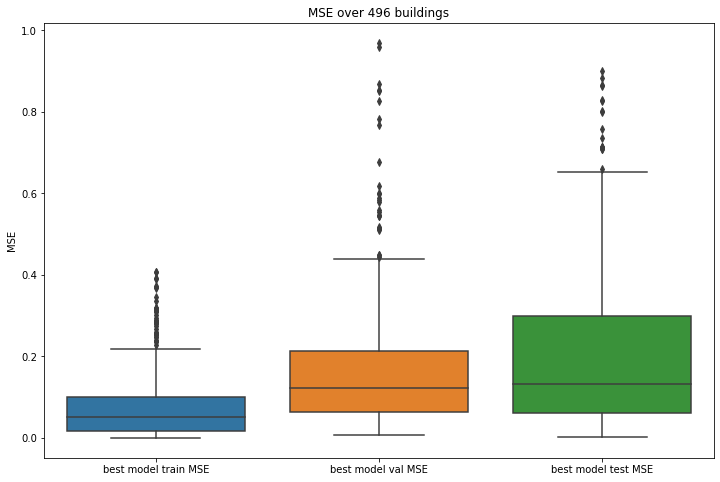

In [14]:
# Use the buildings_model_df to create:

# A boxplot of the best model train MSE, best model val MSE and best model test MSE for each building. Use seaborn to create the boxplot.

fig = plt.figure(figsize = (12, 8))

MSE_df = buildings_models_df[['best model train MSE', 'best model val MSE', 'best model test MSE']]
# remove extreme outliers ("MSE" is between the median and the 95th percentile)
MSE_df = MSE_df[MSE_df['best model train MSE'] < MSE_df['best model train MSE'].quantile(0.95)]
MSE_df = MSE_df[MSE_df['best model val MSE'] < MSE_df['best model val MSE'].quantile(0.95)]
MSE_df = MSE_df[MSE_df['best model test MSE'] < MSE_df['best model test MSE'].quantile(0.95)]

sns.boxplot(data = MSE_df)
plt.ylabel('MSE')
plt.title(f'MSE over {len(buildings_models_df)} buildings')
plt.show()


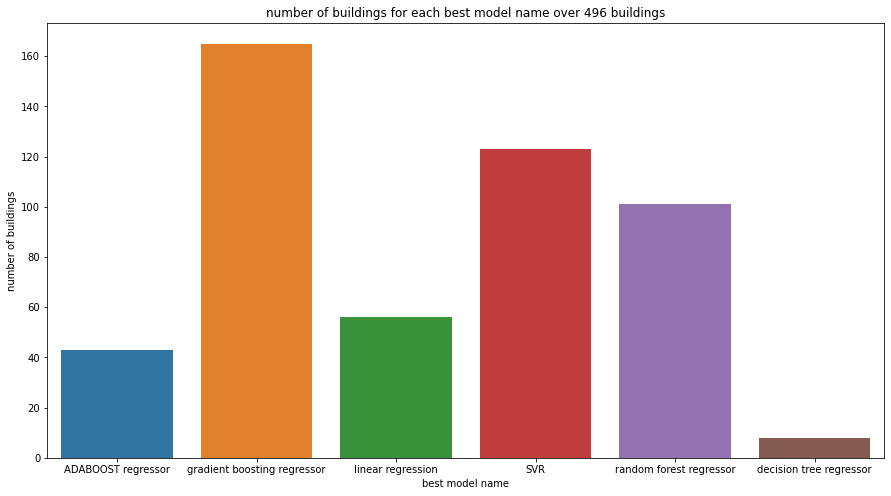

In [15]:
# Create a bar plot of the number of buildings for each best model name. Use seaborn to create the bar plot.
fig = plt.figure(figsize = (15, 8))
sns.countplot(data = buildings_models_df, x = 'best model name')
plt.xlabel('best model name')
plt.ylabel('number of buildings')
plt.title(f'number of buildings for each best model name over {len(buildings_models_df)} buildings')
plt.show()

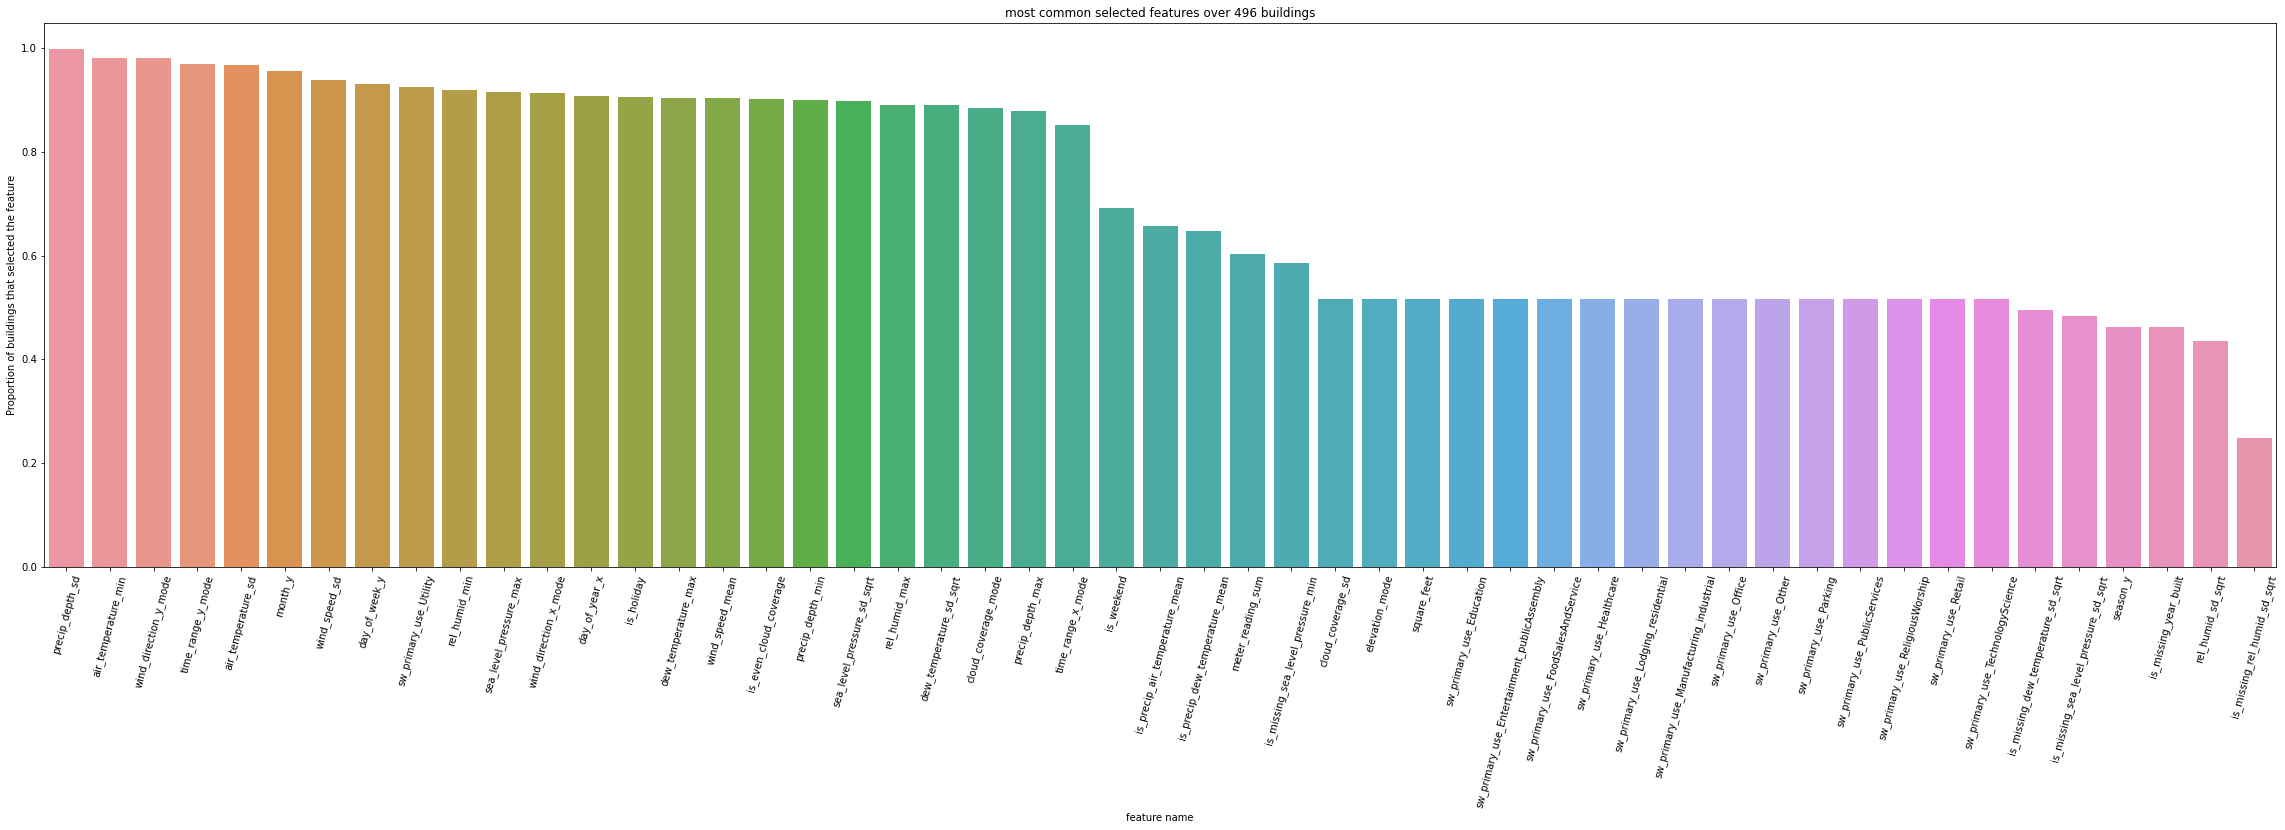

In [16]:
# for each building, extract a list of the selected features
selected_features = []
for i in range(len(buildings_models_df)):
    selected_features.append(list(buildings_models_df['selected features'][i]))

# find the most common selected features
#  flatten the list of lists and create a single list that contains all the selected features from all the buildings
most_common_selected_features = Counter([feature for features in selected_features for feature in features]).most_common()

# plot the most common selected features in a bar plot (use seaborn)
fig = plt.figure(figsize = (40, 10))
sns.barplot(x = [feature[0] for feature in most_common_selected_features], y = [feature[1] / len(selected_features) for feature in most_common_selected_features])
plt.xticks(rotation = 75)
plt.xlabel('feature name')
plt.ylabel('Proportion of buildings that selected the feature')
plt.title(f'most common selected features over {len(buildings_models_df)} buildings')
plt.show()